##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG16, ResNet50 , MobileNetV2,InceptionV3, DenseNet121,EfficientNetB0,NASNetMobile
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


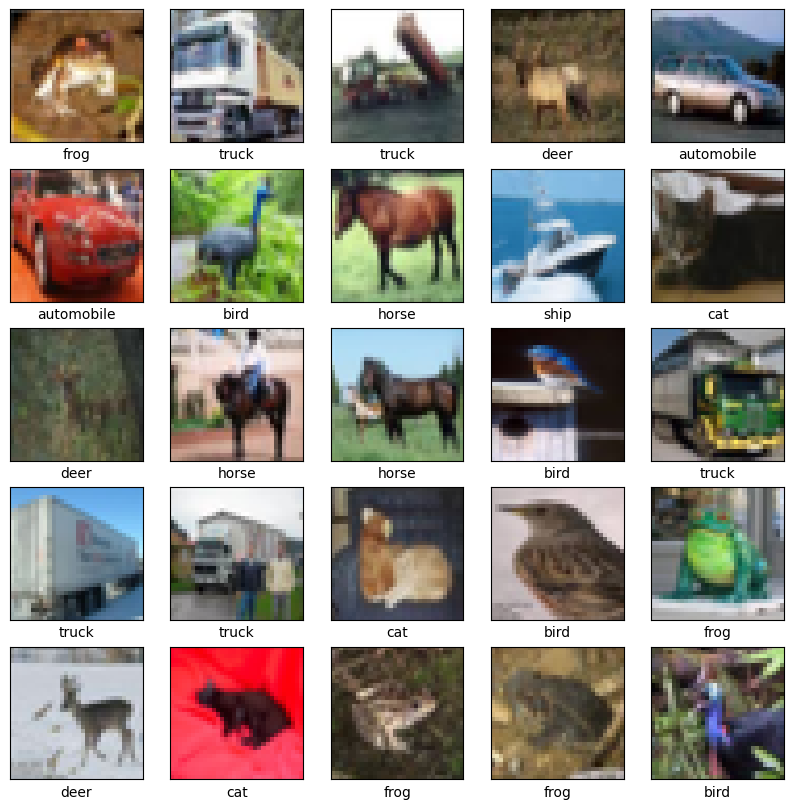

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's display the architecture of your model so far:

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3578 - loss: 1.7352 - val_accuracy: 0.5557 - val_loss: 1.2338
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5860 - loss: 1.1615 - val_accuracy: 0.6364 - val_loss: 1.0265
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6503 - loss: 0.9967 - val_accuracy: 0.6475 - val_loss: 1.0141
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6880 - loss: 0.8849 - val_accuracy: 0.6837 - val_loss: 0.9086
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7198 - loss: 0.7998 - val_accuracy: 0.7001 - val_loss: 0.8629
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7365 - loss: 0.7487 - val_accuracy: 0.7011 - val_loss: 0.8647
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7597 - loss: 0.6779 - val_accuracy: 0.7186 - val_loss: 0.8201
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7743 - loss: 0.6438 -

### Evaluate the model

313/313 - 1s - 2ms/step - accuracy: 0.7131 - loss: 0.8883


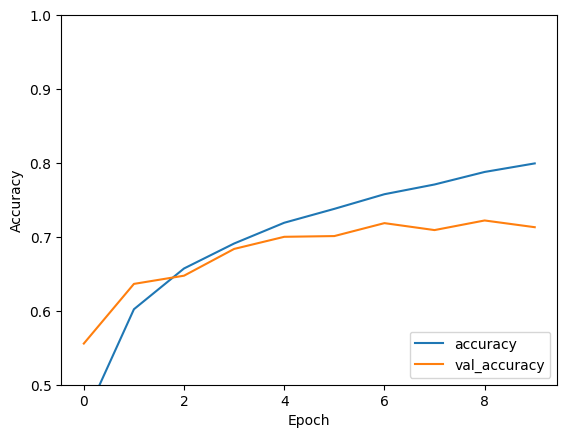

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [12]:
print(test_acc)

0.713100016117096


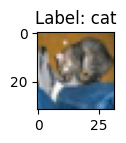

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


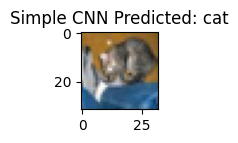

In [17]:
# Predict on a single test image
single_test_image = test_images[0]
single_test_image = single_test_image.reshape(1, 32, 32, 3)  # Reshape to match the input shape

# Display a single test image
plt.figure(figsize=(1, 1))
plt.imshow(single_test_image[0])
plt.title(f'Label: {class_names[test_labels[0][0]]}')
plt.show()


# Get the prediction for the simple CNN model
predictions = model.predict(single_test_image)
predicted_class = class_names[tf.argmax(predictions[0])]

# Display the image and the predicted class for the simple CNN model
plt.figure(figsize=(1, 1))
plt.imshow(test_images[0])
plt.title(f'Simple CNN Predicted: {predicted_class}')
plt.show()


In [ ]:
#resize dataset for other pretrained models
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
def resize_image(image):
  img = Image.fromarray(image)
  resized_img =img.resize((224,224))
  return np.array(resized_img)

train_images = np.array([resize_image(img) for img in train_images])
test_images = np.array([resize_image(img) for img in test_images])


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.4474 - loss: 1.5784 - val_accuracy: 0.5557 - val_loss: 1.2735
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5673 - loss: 1.2285 - val_accuracy: 0.5727 - val_loss: 1.2162
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.5937 - loss: 1.1596 - val_accuracy: 0.5809 - val_loss: 1.1932
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6068 - loss: 1.1290 - val_accuracy: 0.5807 - val_loss: 1.1904
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6163 - loss: 1.0998 - val_accuracy: 0.5940 - val_loss: 1.1649
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6194 - loss: 1.0879 - val_accuracy: 0.5928 - val_loss: 1.1718
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6287 - loss: 1.0599 - val_accuracy: 0.5996 - val_loss: 1.1572
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6268 - loss: 

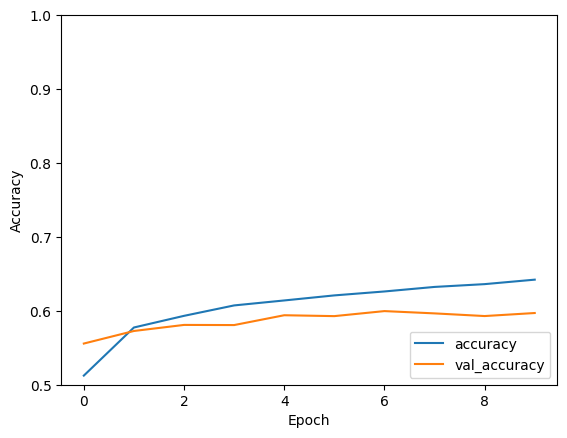

In [4]:
# Create a new model using VGG16 with ImageNet weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of VGG16
for layer in vgg_model.layers:
  layer.trainable = False

# Add custom layers on top of VGG16
new_model = models.Sequential()
new_model.add(vgg_model)
new_model.add(layers.Flatten())
new_model.add(layers.Dense(64, activation='relu'))
new_model.add(layers.Dense(10))

# Compile the new model
new_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

# Train the new model
new_history = new_model.fit(train_images, train_labels, epochs=10,
              validation_data=(test_images, test_labels))

# Evaluate the new model
plt.plot(new_history.history['accuracy'], label='accuracy')
plt.plot(new_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

new_test_loss, new_test_acc = new_model.evaluate(test_images, test_labels, verbose=2)

print(new_test_acc)

In [20]:
# Print model summary for VGG16 based model
new_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,815,136 (56.52 MB)

 Trainable params: 33,482 (130.79 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 66,966 (261.59 KB)

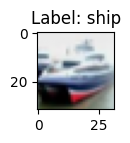

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


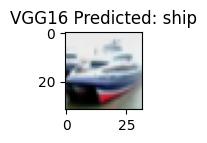

In [28]:
# Predict on a single test image
single_test_image = test_images[1]
single_test_image = single_test_image.reshape(1, 32, 32, 3)  # Reshape to match the input shape

# Display a single test image
plt.figure(figsize=(1, 1))
plt.imshow(single_test_image[0])
plt.title(f'Label: {class_names[test_labels[1][0]]}')
plt.show()

# Get the prediction for the VGG16 model
vgg_predictions = new_model.predict(single_test_image)
vgg_predicted_class = class_names[tf.argmax(vgg_predictions[0])]

# Display the image and the predicted class for the VGG16 model
plt.figure(figsize=(1, 1))
plt.imshow(test_images[1])
plt.title(f'VGG16 Predicted: {vgg_predicted_class}')
plt.show()

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.1935 - loss: 2.1853 - val_accuracy: 0.2985 - val_loss: 1.9132
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3069 - loss: 1.9052 - val_accuracy: 0.2928 - val_loss: 1.9183
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3302 - loss: 1.8508 - val_accuracy: 0.3586 - val_loss: 1.7977
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3489 - loss: 1.8036 - val_accuracy: 0.3498 - val_loss: 1.8098
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3561 - loss: 1.7827 - val_accuracy: 0.3810 - val_loss: 1.7352
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3664 - loss: 1.7660 - val_accuracy: 0.3679 - val_loss: 1.7387
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3727 - loss: 1.7407 - val_accuracy: 0.3754 - val_loss: 1.7153
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.3789 - loss: 

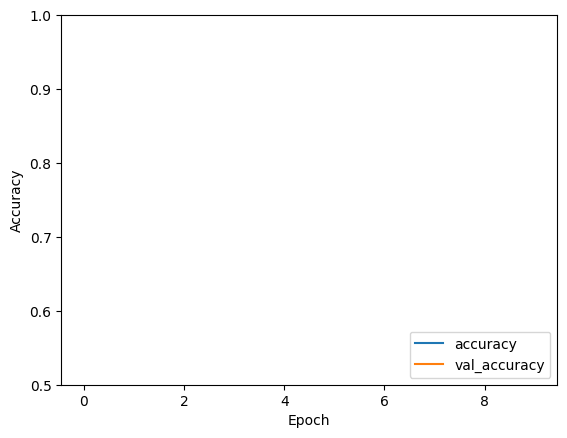

In [6]:

# Define the ResNet50 model with the new input shape
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of ResNet50
for layer in resnet_model.layers:
  layer.trainable = False

# Add custom layers on top of ResNet50
new_resnet_model = models.Sequential()
new_resnet_model.add(resnet_model)
new_resnet_model.add(layers.Flatten())
new_resnet_model.add(layers.Dense(64, activation='relu'))
new_resnet_model.add(layers.Dense(10))

# Compile the new model
new_resnet_model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

# Train the new model
new_resnet_history = new_resnet_model.fit(train_images, train_labels, epochs=10,
                      validation_data=(test_images, test_labels))

# Evaluate the new model
plt.plot(new_resnet_history.history['accuracy'], label='accuracy')
plt.plot(new_resnet_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

new_resnet_test_loss, new_resnet_test_acc = new_resnet_model.evaluate(test_images, test_labels, verbose=2)

print(new_resnet_test_acc)


In [7]:
new_resnet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,983,072 (91.49 MB)

 Trainable params: 131,786 (514.79 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 263,574 (1.01 MB)

The Accuracy of the ResNET50 model is only 39% as it is optimized for image size of (224,224). We can resize the images and use it for its full potential.


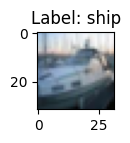

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


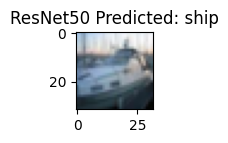

In [14]:
# Predict on a single test image
single_test_image = test_images[2]
single_test_image = single_test_image.reshape(1, 32, 32, 3)  # Reshape to match the input shape

# Display a single test image
plt.figure(figsize=(1, 1))
plt.imshow(single_test_image[0])
plt.title(f'Label: {class_names[test_labels[2][0]]}')
plt.show()
# Get the prediction for the ResNet50 model
resnet_predictions = new_resnet_model.predict(single_test_image)
resnet_predicted_class = class_names[tf.argmax(resnet_predictions[0])]

# Display the image and the predicted class for the ResNet50 model
plt.figure(figsize=(1, 1))

plt.imshow(test_images[2])
plt.title(f'ResNet50 Predicted: {resnet_predicted_class}')
plt.show()


<ipython-input-7-fbccba69ac40>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2604 - loss: 2.0444 - val_accuracy: 0.3187 - val_loss: 1.8790
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3302 - loss: 1.8530 - val_accuracy: 0.3240 - val_loss: 1.8555
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3393 - loss: 1.8232 - val_accuracy: 0.3438 - val_loss: 1.8271
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3542 - loss: 1.7869 - val_accuracy: 0.3426 - val_loss: 1.8168
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3563 - loss: 1.7714 - val_accuracy: 0.3452 - val_loss: 1.8126
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3641 - loss: 1.7531 - val_accuracy: 0.3445 - val_loss: 1.8096
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.3687 - loss: 1.7446 - val_accuracy: 0.3452 - val_loss: 1.8070
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3706 - loss: 

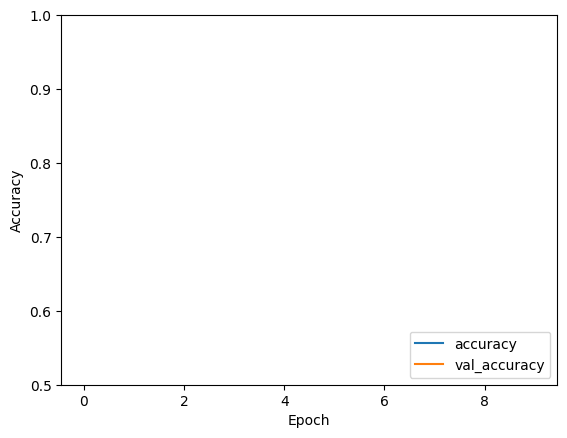

In [7]:
# Create a new model using MobileNetV2 with ImageNet weights
mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of MobileNetV2
for layer in mobilenet_model.layers:
  layer.trainable = False

# Add custom layers on top of MobileNetV2
new_mobilenet_model = models.Sequential()
new_mobilenet_model.add(mobilenet_model)
new_mobilenet_model.add(layers.Flatten())
new_mobilenet_model.add(layers.Dense(64, activation='relu'))
new_mobilenet_model.add(layers.Dense(10))

# Compile the new model
new_mobilenet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the new model
new_mobilenet_history = new_mobilenet_model.fit(train_images, train_labels, epochs=10,
                        validation_data=(test_images, test_labels))

# Evaluate the new model
plt.plot(new_mobilenet_history.history['accuracy'], label='accuracy')
plt.plot(new_mobilenet_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

new_mobilenet_test_loss, new_mobilenet_test_acc = new_mobilenet_model.evaluate(test_images, test_labels, verbose=2)

print(new_mobilenet_test_acc)

In [8]:
new_mobilenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1, 1, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,505,888 (9.56 MB)

 Trainable params: 82,634 (322.79 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 165,270 (645.59 KB)

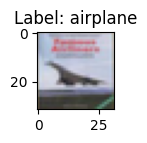

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


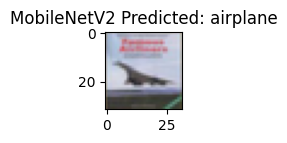

In [20]:
# Predict on a single test image
single_test_image = test_images[3]
single_test_image = single_test_image.reshape(1, 32, 32, 3)  # Reshape to match the input shape

# Display a single test image
plt.figure(figsize=(1, 1))
plt.imshow(single_test_image[0])
plt.title(f'Label: {class_names[test_labels[3][0]]}')
plt.show()
# Get the prediction for the MobileNetV2 model
mobilenet_predictions = new_mobilenet_model.predict(single_test_image)
mobilenet_predicted_class = class_names[tf.argmax(mobilenet_predictions[0])]

# Display the image and the predicted class for the MobileNetV2 model
plt.figure(figsize=(1, 1))
plt.imshow(test_images[3])
plt.title(f'MobileNetV2 Predicted: {mobilenet_predicted_class}')
plt.show()


In [22]:
# Create a new model using InceptionV3 with ImageNet weights
inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of InceptionV3
for layer in inception_model.layers:
  layer.trainable = False

# Add custom layers on top of InceptionV3
new_inception_model = models.Sequential()
new_inception_model.add(inception_model)
new_inception_model.add(layers.Flatten())
new_inception_model.add(layers.Dense(64, activation='relu'))
new_inception_model.add(layers.Dense(10))

# Compile the new model
new_inception_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the new model
new_inception_history = new_inception_model.fit(train_images, train_labels, epochs=10,
                        validation_data=(test_images, test_labels))

# Evaluate the new model
plt.plot(new_inception_history.history['accuracy'], label='accuracy')
plt.plot(new_inception_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

new_inception_test_loss, new_inception_test_acc = new_inception_model.evaluate(test_images, test_labels, verbose=2)

print(new_inception_test_acc)



ValueError: Input size must be at least 75x75; Received: input_shape=(32, 32, 3)

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.

In [ ]:
# Create a new model using EfficientNetB0 with ImageNet weights
efficientnet_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of EfficientNetB0
for layer in efficientnet_model.layers:
  layer.trainable = False

# Add custom layers on top of EfficientNetB0
new_efficientnet_model = models.Sequential()
new_efficientnet_model.add(efficientnet_model)
new_efficientnet_model.add(layers.Flatten())
new_efficientnet_model.add(layers.Dense(64, activation='relu'))
new_efficientnet_model.add(layers.Dense(10))

# Compile the new model
new_efficientnet_model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

# Train the new model
new_efficientnet_history = new_efficientnet_model.fit(train_images, train_labels, epochs=10,
            validation_data=(test_images, test_labels))

# Evaluate the new model
plt.plot(new_efficientnet_history.history['accuracy'], label='accuracy')
plt.plot(new_efficientnet_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

new_efficientnet_test_loss, new_efficientnet_test_acc = new_efficientnet_model.evaluate(test_images, test_labels, verbose=2)

print(new_efficientnet_test_acc)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 78ms/step - accuracy: 0.1017 - loss: 2.3075 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/10
